In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import qnmfits
import analytic_fit
import utils
import corner

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)

We can get an idea of whether our choice of the noise floor is conservative enough with the following process:

1. Create an injection based on a CCE waveform, which includes the $(3,2,0)$ mode. Perhaps ideally you would want to pick the $(3,2,0)$ amplitude carefully from a stable window.
2. Perform a Bayesian fit to the injection where we don't include the $(3,2,0)$ mode in our model, but attempt to compensate with a appropriate choice of $\sigma$.
3. If the truths lie within the 90% credible region, then the choice of $\sigma$ is sufficient.

In [3]:
ID = 1

In [4]:
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [5]:
t0_list = np.linspace(-10, 100, 111)
modes = [(2,2,0,1), (3,2,0,1)]

C_at_peak_list = []
for t0_trial in t0_list:
    bf = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes=modes,
        Mf=Mf,
        chif=chif,
        t0=t0_trial,
        t0_method='closest',
        T=100
    )
    C_at_peak = []
    for C, omega in zip(bf['C'], bf['frequencies']):
        C_at_peak.append(C*np.exp(-1j*omega*(-t0_trial)))
    C_at_peak_list.append(C_at_peak)

In [6]:
omega_list = bf['frequencies']

In [7]:
omega_220 = omega_list[0]
omega_320 = omega_list[1]

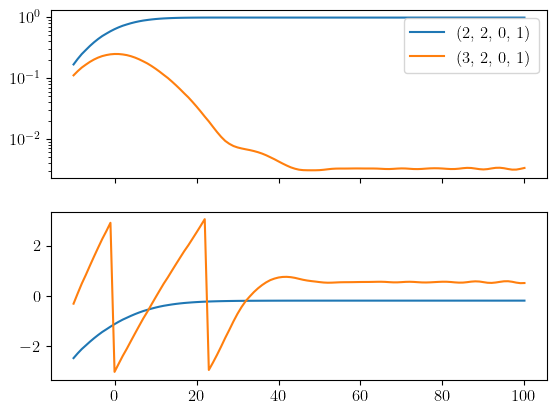

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_yscale('log')

for i, mode in enumerate(modes):
    axs[0].plot(t0_list, np.abs([C[i] for C in C_at_peak_list]), label=str(mode))
    axs[1].plot(t0_list, np.angle([C[i] for C in C_at_peak_list]), label=str(mode))

axs[0].legend();

In [9]:
A220_at_peak_list = np.abs([C[0] for C in C_at_peak_list])
phi220_at_peak_list = np.angle([C[0] for C in C_at_peak_list])

A320_at_peak_list = np.abs([C[1] for C in C_at_peak_list])
phi320_at_peak_list = np.angle([C[1] for C in C_at_peak_list])

In [10]:
window_size = 10

best_std = np.inf
best_window_start = 0

for i in range(len(t0_list)-window_size):
    window_amp = A220_at_peak_list[i:i+window_size]
    window_phase = phi220_at_peak_list[i:i+window_size]
    std_amp = np.std(window_amp)
    std_phase = np.std(window_phase)
    std = std_amp + std_phase
    if std < best_std:
        best_std = std
        best_window_start = i

A220_at_peak_stable = A220_at_peak_list[best_window_start:best_window_start+window_size]
phi220_at_peak_stable = phi220_at_peak_list[best_window_start:best_window_start+window_size]
C220_stable_times = t0_list[best_window_start:best_window_start+window_size]

A220_at_peak_bestfit = np.mean(A220_at_peak_stable)
phi220_at_peak_bestfit = np.mean(phi220_at_peak_stable)
time_bestfit = np.mean(C220_stable_times)

In [11]:
window_size = 10

best_std = np.inf
best_window_start = 0

for i in range(len(t0_list)-window_size):
    window_amp = A320_at_peak_list[i:i+window_size]
    window_phase = phi320_at_peak_list[i:i+window_size]
    std_amp = np.std(window_amp)
    std_phase = np.std(window_phase)
    std = std_amp + std_phase
    if std < best_std:
        best_std = std
        best_window_start = i

A320_at_peak_stable = A320_at_peak_list[best_window_start:best_window_start+window_size]
phi320_at_peak_stable = phi320_at_peak_list[best_window_start:best_window_start+window_size]
C320_stable_times = t0_list[best_window_start:best_window_start+window_size]

A320_at_peak_bestfit = np.mean(A320_at_peak_stable)
phi320_at_peak_bestfit = np.mean(phi320_at_peak_stable)
time_bestfit = np.mean(C320_stable_times)

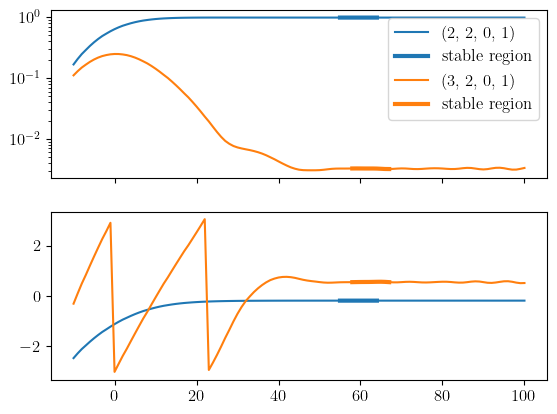

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_yscale('log')

axs[0].plot(t0_list, A220_at_peak_list, label=str(modes[0]), c='C0')
axs[0].plot(C220_stable_times, A220_at_peak_stable, label='stable region', c='C0', lw=3)

axs[0].plot(t0_list, A320_at_peak_list, label=str(modes[1]), c='C1')
axs[0].plot(C320_stable_times, A320_at_peak_stable, label='stable region', c='C1', lw=3)

axs[1].plot(t0_list, phi220_at_peak_list, label=str(modes[0]), c='C0')
axs[1].plot(C220_stable_times, phi220_at_peak_stable, label='stable region', c='C0', lw=3)

axs[1].plot(t0_list, phi320_at_peak_list, label=str(modes[1]), c='C1')
axs[1].plot(C320_stable_times, phi320_at_peak_stable, label='stable region', c='C1', lw=3)

axs[0].legend();

In [13]:
plot_mask = (sim.times >= - 20) & (sim.times <= 100)
plot_times = sim.times[plot_mask]

h220 = A220_at_peak_bestfit*np.exp(1j*phi220_at_peak_bestfit)*np.exp(-1j*omega_220*(plot_times))
h320 = A320_at_peak_bestfit*np.exp(1j*phi320_at_peak_bestfit)*np.exp(-1j*omega_320*(plot_times))

In [14]:
h22_real = np.real(sim.h[2,2])[plot_mask].copy()
h320_real = np.real(h320).copy()

In [15]:
# Identify zero crossings in h22_real
zero_crossings = np.where(np.diff(np.sign(h22_real)))[0]

# Insert a small value at the zero crossings to prevent interpolation artifacts
for zc in zero_crossings:
    h22_real[zc] = 1e-10

In [16]:
zero_crossings = np.where(np.diff(np.sign(h320_real)))[0]

for zc in zero_crossings:
    h320_real[zc] = 1e-10

In [17]:
cce_c = "#7A7A7A"

In [18]:
t0 = t0_M[str(ID)].values[3]
t0

np.float64(7.812375333928685)

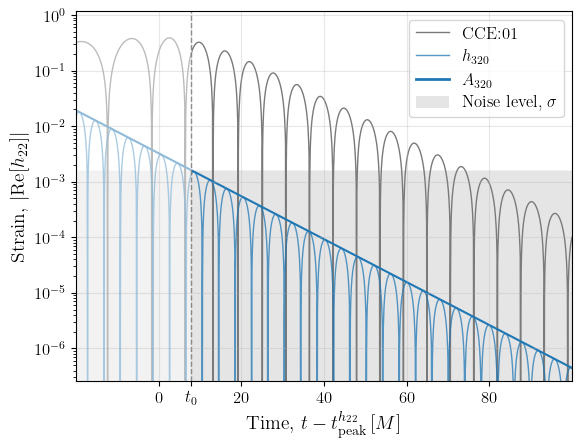

In [19]:
fig, ax = plt.subplots()
ax.grid(visible=True, alpha=0.3)
ax.set_yscale('log')

ax.plot(plot_times, np.abs(h320), c='C0', zorder=1)
ylim_low = ax.get_ylim()[0]

ax.plot(plot_times, np.abs(h320_real), c='C0', lw=1, zorder=1, alpha=0.75)

# ax.plot(plot_times_interp, np.abs(h22_real_interp), c=cce_c, lw=1, zorder=0.5)
ax.plot(plot_times, np.abs(h22_real), c=cce_c, lw=1, zorder=0.5)
ylim_high = ax.get_ylim()[1]

ax.axvline(
    t0, 
    color='k', 
    lw=1, 
    ls='--', 
    alpha=0.5, 
    zorder=1.2,
)

ax.set_xticks([t0, 0, 20, 40, 60, 80])
ax.set_xticklabels(['$t_0$', '0', '20', '40', '60', '80'])

ax.fill_betweenx(
    [ylim_low, ylim_high],
    plot_times[0],
    t0,
    color='w',
    alpha=0.5,
    zorder=1.1,
    # hatch='/'
)

sigma = np.abs(h320)[np.argmin(np.abs(plot_times - t0))]

ax.fill_between(
    plot_times, #  [plot_times > t0],
    ylim_low,
    sigma,
    color='k',
    alpha=0.1,
    zorder=0.3,
    lw=0
)

custom_handles = [
    plt.Line2D([0], [0], color=cce_c, lw=1),
    plt.Line2D([0], [0], color='C0', lw=1, alpha=0.75),
    plt.Line2D([0], [0], color='C0', lw=2),
    mpatches.Patch(facecolor='k', alpha=0.1, lw=0)
]
custom_labels = [
    'CCE:01',
    '$h_{320}$',
    '$A_{320}$',
    'Noise level, $\sigma$',
]
ax.legend(
    custom_handles,
    custom_labels,
    loc='upper right',
)

ax.set_xlim(plot_times[0], plot_times[-1])
ax.set_ylim(ylim_low,ylim_high)

ax.set_xlabel('Time, $t - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('Strain, $|\mathrm{Re}[ h_{22} ]|$')

fig.savefig('figures/noise_level.pdf', bbox_inches='tight')

In [20]:
# Create an injection. We subtract our careful 320 fit first, and then add it
# back in afterwards.

N = 11
T = 100
t0 = t0_M[str(ID)].values[N]

h22_wo_320 = sim.h[2,2][plot_mask] - h320

In [21]:
modes = [(2,2,n,1) for n in range(N+1)]

bf = qnmfits.ringdown_fit(
    sim.times[plot_mask],
    h22_wo_320,
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest',
    T=T
)

In [22]:
injection = bf['model']
injection_times = bf['model_times']
injection_C = bf['C']
injection_omega = bf['frequencies']

In [23]:
injection_times

array([-4.76515618, -4.68705076, -4.60894493, ..., 94.97707496,
       95.05518432, 95.13329368], shape=(1280,))

In [24]:
mask = (plot_times >= injection_times[0]) & (plot_times <= injection_times[-1])
len(h320[mask]), len(injection)

(1280, 1280)

In [25]:
injection_with_320 = injection + h320[mask]

In [26]:
sigma = np.abs(h320)[np.argmin(np.abs(plot_times - t0))]

In [27]:
sigma

np.float64(0.004984598680100192)

In [28]:
t0

np.float64(-4.765156176626988)

In [29]:
re_c_truths = np.real(injection_C)
im_c_truths = np.imag(injection_C)

c_truths = []
for re_c, im_c in zip(re_c_truths, im_c_truths):
    c_truths.append(re_c)
    c_truths.append(im_c)

Perform some Bayesian fits...

In [30]:
injection_data = {
    'plus': np.real(injection_with_320),
    'cross': -np.imag(injection_with_320),
}

If we just use $\sigma = A_{320}$ this seems to be sufficient in this case:

In [31]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=injection_times,
    data=injection_data,
    sigma=sigma*np.ones_like(injection_times),
    qnm_omegas=injection_omega,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

In [32]:
real_labels = [
    rf'$\mathrm{{Re}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
imag_labels = [
    rf'$\mathrm{{Im}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
labels = []
for real, imag in zip(real_labels, imag_labels):
    labels.append(real)
    labels.append(imag)

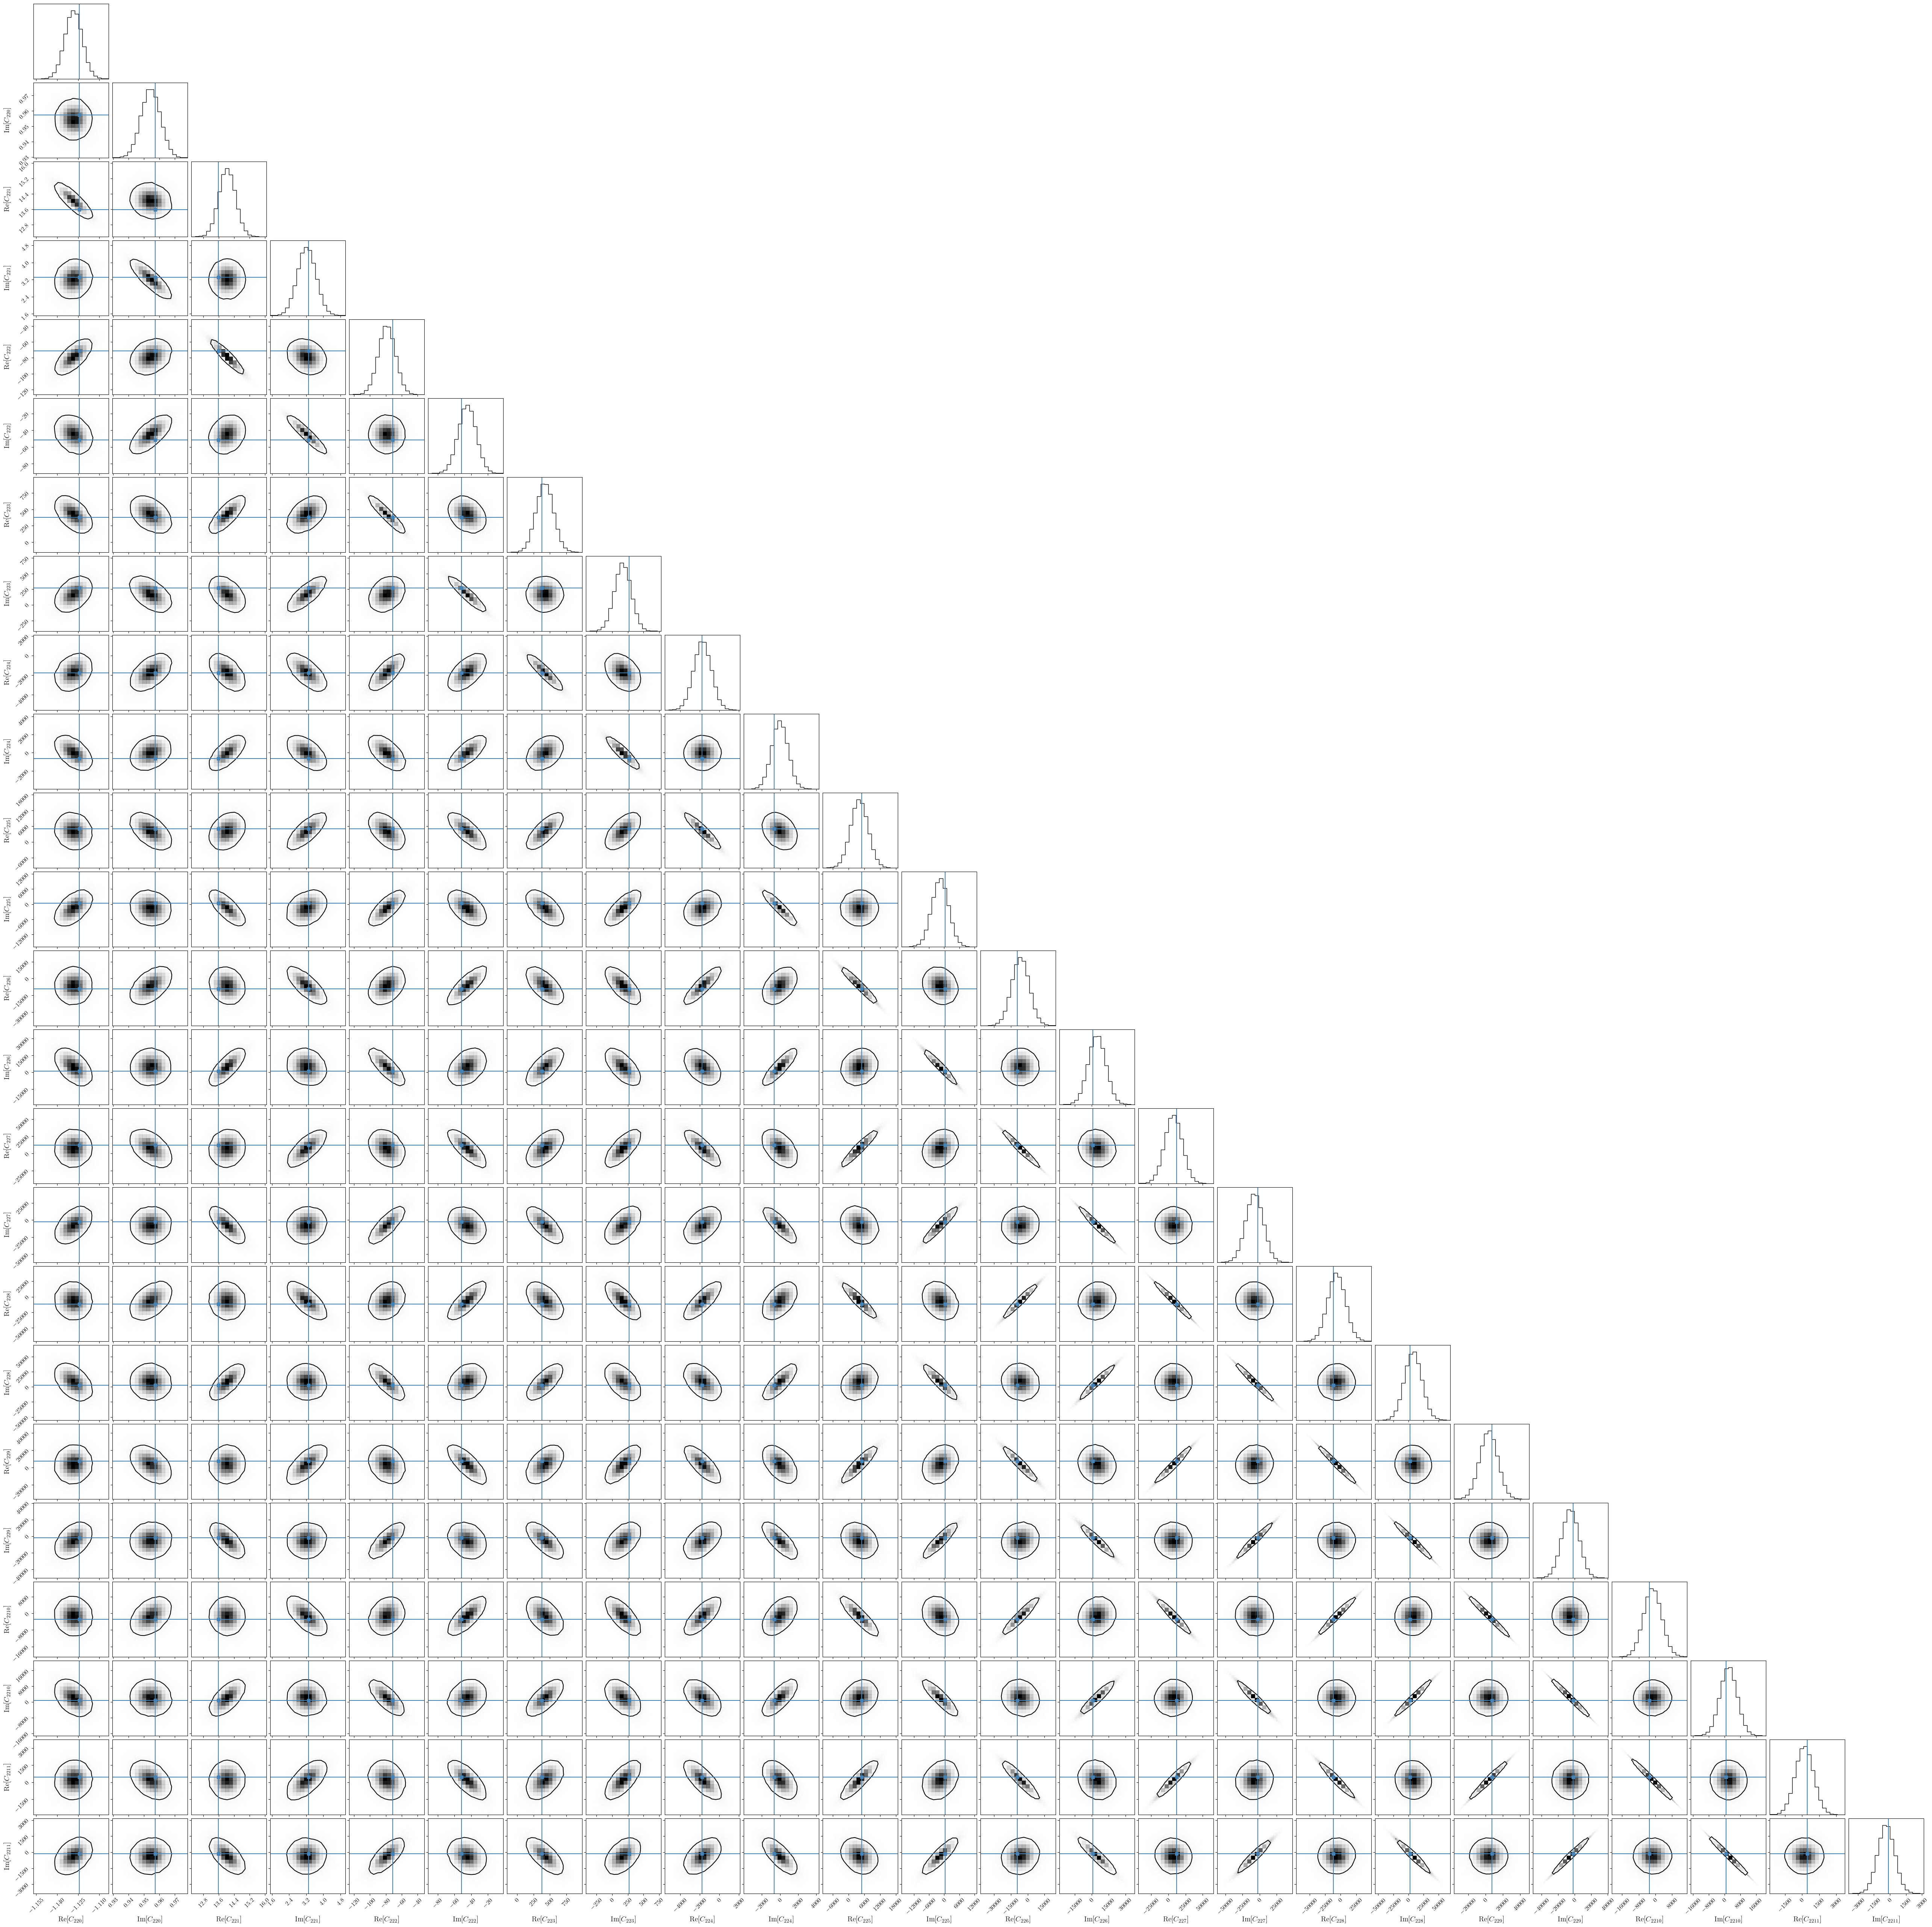

In [33]:
fig = corner.corner(
    analytic_samples,
    levels=[0.9],
    labels=labels,
    truths=c_truths,
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)

In [34]:
for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
    q5, q95 = np.percentile(posterior, [5, 95])
    if truth < q5 or truth > q95:
        print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")

If we use too small a sigma we run into problems...

In [35]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=injection_times,
    data=injection_data,
    sigma=sigma*np.ones_like(injection_times)/5,
    qnm_omegas=injection_omega,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

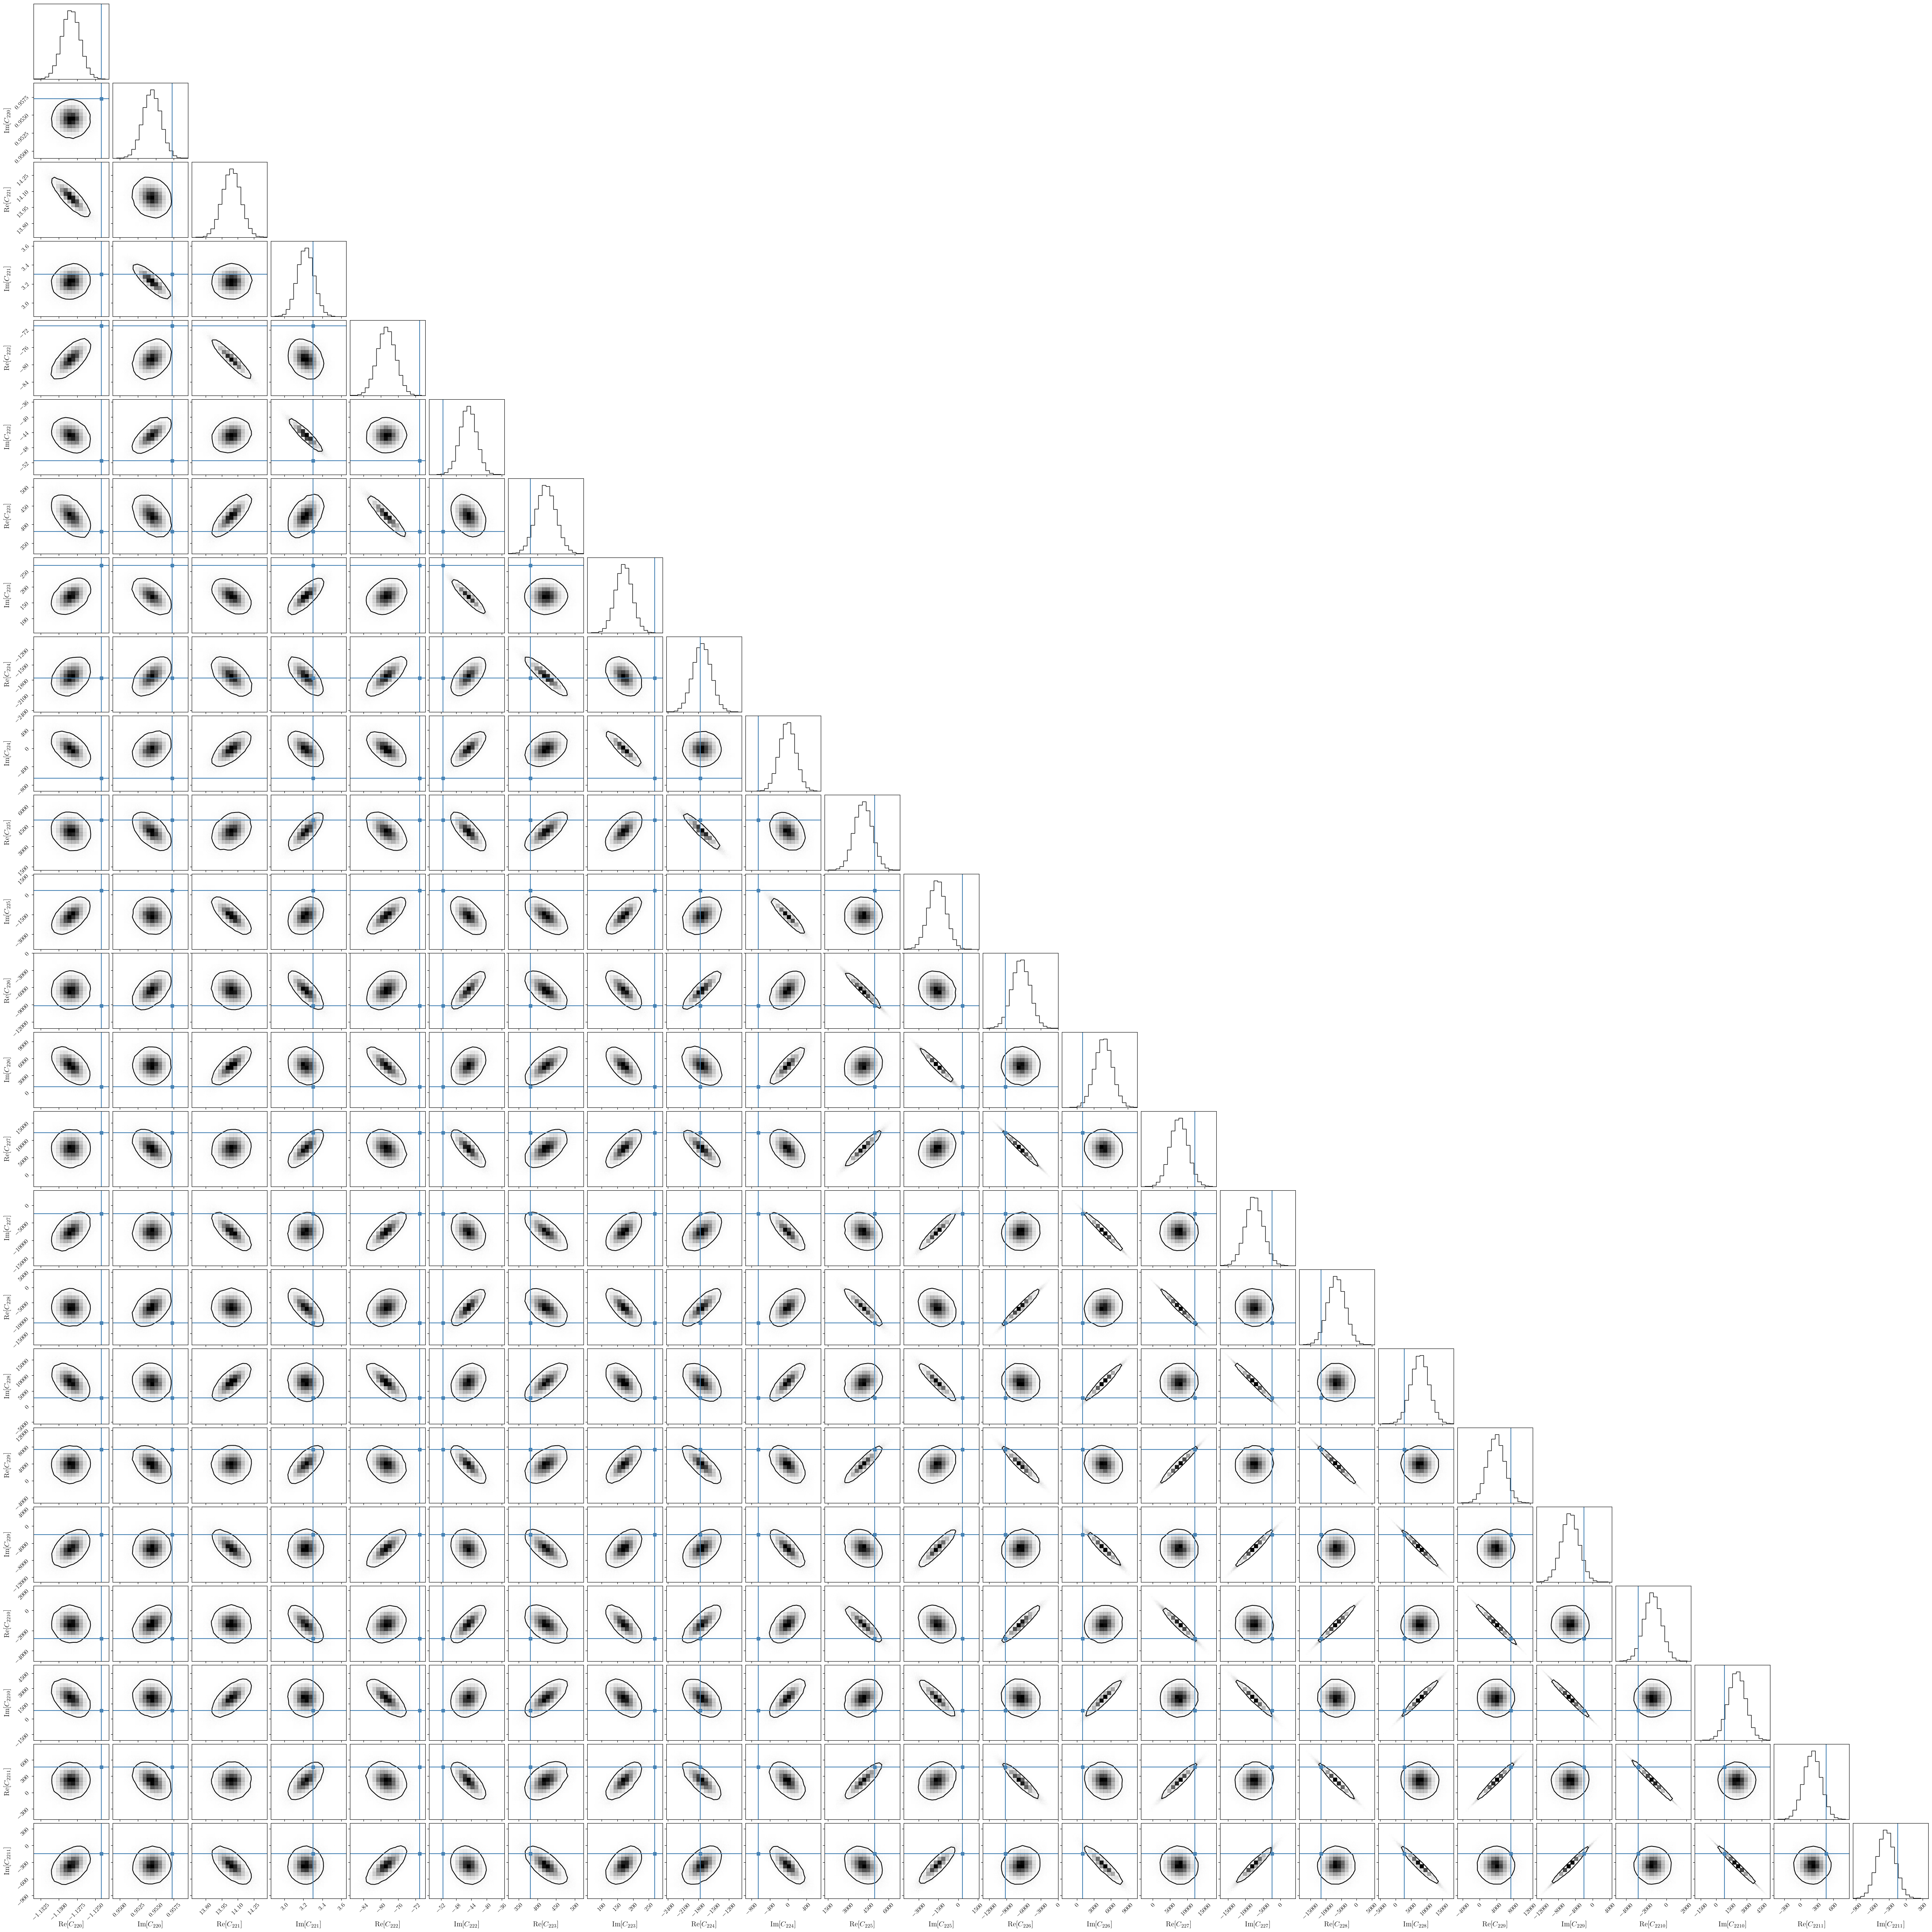

In [36]:
fig = corner.corner(
    analytic_samples,
    levels=[0.9],
    labels=labels,
    truths=c_truths,
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)

In [37]:
for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
    q5, q95 = np.percentile(posterior, [5, 95])
    if truth < q5 or truth > q95:
        print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")

Truth value for parameter 0 is outside the 90% credible interval (-1.1303874353826522, -1.1263053106687966)
Truth value for parameter 1 is outside the 90% credible interval (0.9523829041008451, 0.9564977165097757)
Truth value for parameter 2 is outside the 90% credible interval (13.89895465123507, 14.182913970448551)
Truth value for parameter 4 is outside the 90% credible interval (-82.23743726513415, -75.22688829322645)
Truth value for parameter 5 is outside the 90% credible interval (-48.32432704260562, -41.29253684758346)
Truth value for parameter 7 is outside the 90% credible interval (126.73264270326351, 213.9620845576379)
Truth value for parameter 9 is outside the 90% credible interval (-308.60711655267005, 279.07605055951007)
Truth value for parameter 11 is outside the 90% credible interval (-2677.631325811567, -503.31003904484965)
Truth value for parameter 12 is outside the 90% credible interval (-9067.933969934142, -3907.753768120094)
Truth value for parameter 13 is outside th

Repeat for all IDs

In [38]:
def get_stable_window(sim, modes, chif, Mf, t0_list, window_size=10):

    C_at_peak_list = []
    for t0_trial in t0_list:
        bf = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes=modes,
            Mf=Mf,
            chif=chif,
            t0=t0_trial,
            t0_method='closest',
            T=100
        )
        C_at_peak = []
        for C, omega in zip(bf['C'], bf['frequencies']):
            C_at_peak.append(C*np.exp(-1j*omega*(-t0_trial)))
        C_at_peak_list.append(C_at_peak)

    best_windows = []

    for i_mode in range(len(modes)):

        A_at_peak_list = np.abs([C[i_mode] for C in C_at_peak_list])
        phi_at_peak_list = np.angle([C[i_mode] for C in C_at_peak_list])

        best_std = np.inf
        best_window_start = 0

        for i in range(len(t0_list)-window_size):
            window_amp = A_at_peak_list[i:i+window_size]
            window_phase = phi_at_peak_list[i:i+window_size]
            std_amp = np.std(window_amp)
            std_phase = np.std(window_phase)
            std = std_amp + std_phase
            if std < best_std:
                best_std = std
                best_window_start = i

        A_at_peak_stable = A_at_peak_list[best_window_start:best_window_start+window_size]
        phi_at_peak_stable = phi_at_peak_list[best_window_start:best_window_start+window_size]
        C_stable_times = t0_list[best_window_start:best_window_start+window_size]

        A_at_peak_bestfit = np.mean(A_at_peak_stable)
        phi_at_peak_bestfit = np.mean(phi_at_peak_stable)
        time_bestfit = np.mean(C_stable_times)

        best_windows.append({
            'A_bestfit': A_at_peak_bestfit,
            'phi_bestfit': phi_at_peak_bestfit,
            'time_bestfit': time_bestfit,
            'A_stable': A_at_peak_stable,
            'phi_stable': phi_at_peak_stable,
            'times_stable': C_stable_times,
            'A_peak': A_at_peak_list,
            'phi_peak': phi_at_peak_list,
            't0_list': t0_list,
            'mode': modes[i_mode],
        })

    return best_windows

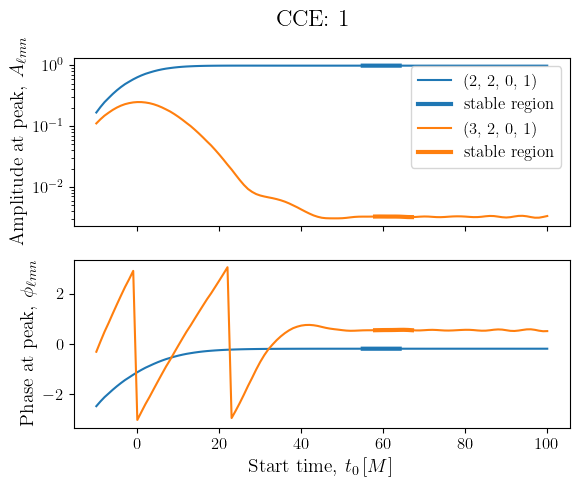

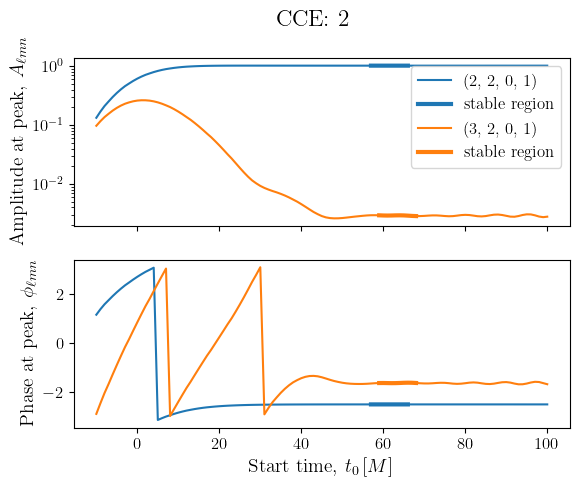

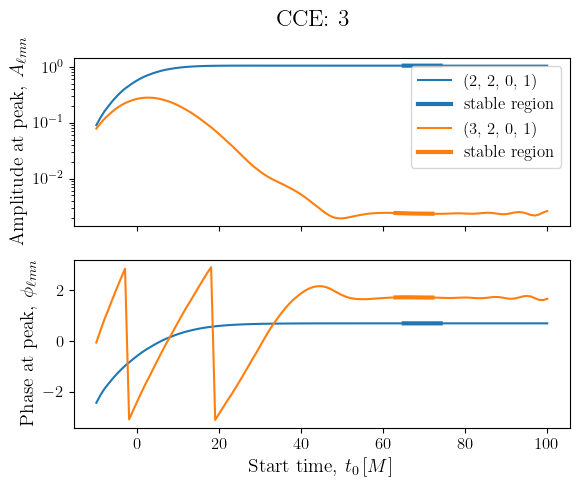

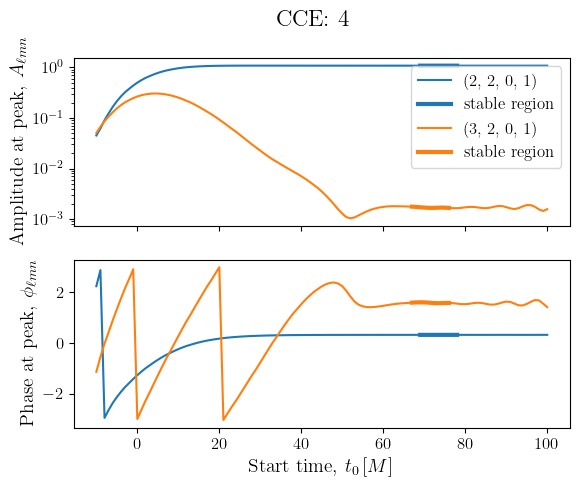

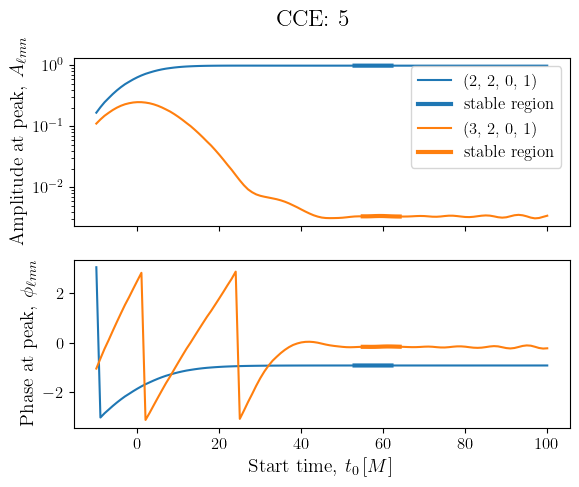

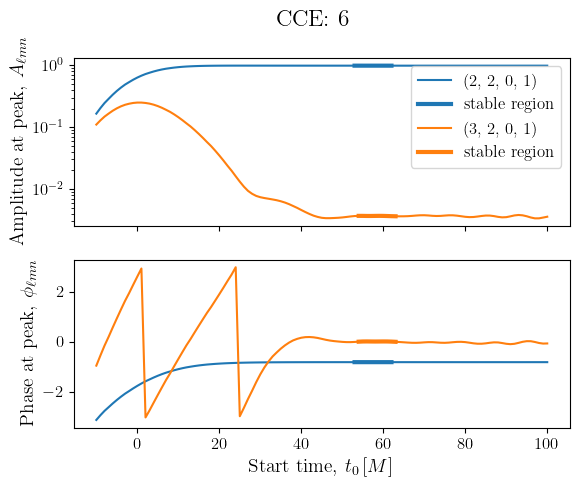

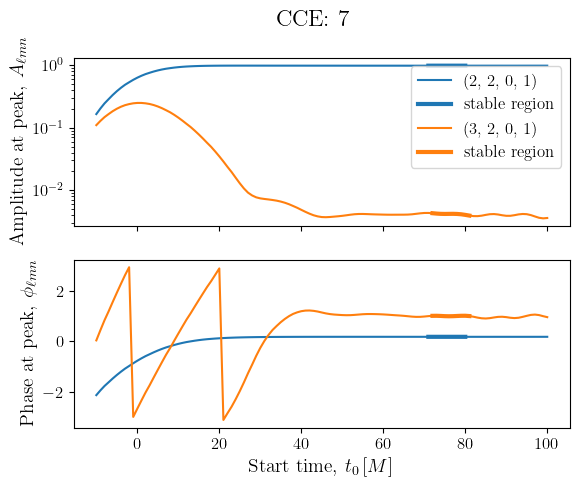

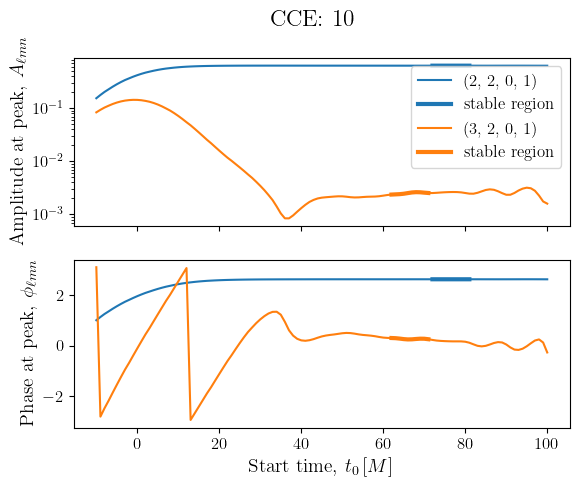

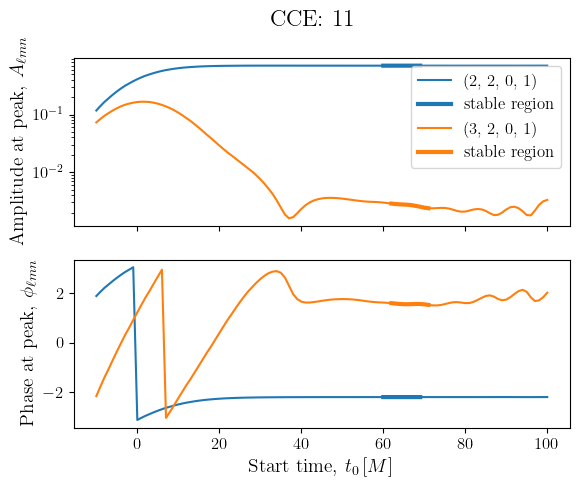

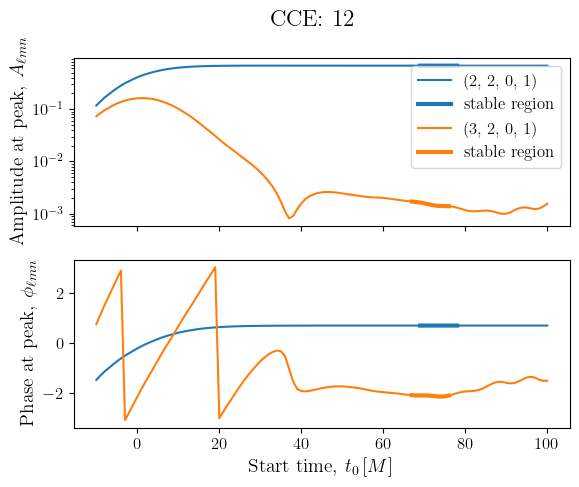

In [39]:
for ID in t0_M.columns:

    ID = int(ID)

    sim_info = utils.load_cce_data(ID)
    sim = sim_info['sim']
    chif = sim.chif_mag
    Mf = sim.Mf

    best_windows = get_stable_window(
        sim,
        modes=[(2,2,0,1), (3,2,0,1)],
        chif=chif,
        Mf=Mf,
        t0_list=np.linspace(-10, 100, 111),
        window_size=10
    )

    fig, axs = plt.subplots(2, 1, sharex=True)
    fig.suptitle(f'CCE: {ID}')
    axs[0].set_yscale('log')

    for i, entry in enumerate(best_windows):

        mode = entry['mode']

        axs[0].plot(entry['t0_list'], entry['A_peak'], label=str(mode), c=f'C{i}')
        axs[0].plot(entry['times_stable'], entry['A_stable'], label='stable region', c=f'C{i}', lw=3)

        axs[1].plot(entry['t0_list'], entry['phi_peak'], c=f'C{i}')
        axs[1].plot(entry['times_stable'], entry['phi_stable'], c=f'C{i}', lw=3)

    axs[0].legend()

    axs[0].set_ylabel('Amplitude at peak, $A_{\\ell mn}$')
    axs[1].set_ylabel('Phase at peak, $\\phi_{\\ell mn}$')
    axs[1].set_xlabel('Start time, $t_0\, [M]$')

    plt.show()

    A320_at_peak_bestfit = best_windows[1]['A_bestfit']
    phi320_at_peak_bestfit = best_windows[1]['phi_bestfit']
    omega_320 = qnmfits.qnm.omega(3, 2, 0, 1, chif=chif, Mf=Mf)

    analysis_mask = (sim.times >= - 20) & (sim.times <= 100)
    analysis_times = sim.times[analysis_mask]

    h320 = A320_at_peak_bestfit*np.exp(1j*phi320_at_peak_bestfit)*np.exp(-1j*omega_320*(analysis_times))

    N = 11
    T = 100
    t0 = t0_M[str(ID)].values[N]

    modes = [(2,2,n,1) for n in range(N+1)]

    h22_wo_320 = sim.h[2,2][analysis_mask] - h320

    bf = qnmfits.ringdown_fit(
        analysis_times,
        h22_wo_320,
        modes=modes,
        Mf=Mf,
        chif=chif,
        t0=t0,
        t0_method='closest',
        T=T
    )

    injection = bf['model']
    injection_times = bf['model_times']
    injection_C = bf['C']
    injection_omega = bf['frequencies']

    mask = (analysis_times >= injection_times[0]) & (analysis_times <= injection_times[-1])
    injection_with_320 = injection + h320[mask]

    sigma = np.abs(h320)[np.argmin(np.abs(analysis_times - t0))]

    re_c_truths = np.real(injection_C)
    im_c_truths = np.imag(injection_C)

    c_truths = []
    for re_c, im_c in zip(re_c_truths, im_c_truths):
        c_truths.append(re_c)
        c_truths.append(im_c)

    injection_data = {
        'plus': np.real(injection_with_320),
        'cross': -np.imag(injection_with_320),
    }

    analytic_samples, A_samples, phi_samples = analytic_fit.sample(
        times=injection_times,
        data=injection_data,
        sigma=sigma*np.ones_like(injection_times),
        qnm_omegas=injection_omega,
        t0=t0,
        t0_method='closest',
        T=T,
        reweight=False,
    )

    for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
        q5, q95 = np.percentile(posterior, [5, 95])
        if truth < q5 or truth > q95:
            print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")